In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from matplotlib import pyplot as plt


In [2]:

transform = transforms.Compose(
    [
        transforms.CenterCrop((500, 500)),
        transforms.Resize(224),
        transforms.ToTensor(),
     ])
train_dataset = datasets.Flowers102('data', split = 'train', download=True, transform=transform)
validation_dataset = datasets.Flowers102('data', split = 'val', download=True, transform=transform)
test_dataset = datasets.Flowers102('data', split = 'test', download=True, transform=transform)


  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting data/flowers-102/102flowers.tgz to data/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [3]:
phases = {
    'train': train_dataset,
    'valid': validation_dataset,
    'test': test_dataset
    }
loader = {
    phase: DataLoader(ds, batch_size=32, shuffle=(phase=='train'))
    for phase, ds in phases.items()
}

In [4]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [5]:
def visualize(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))
  plt.xticks([])
  plt.yticks([])


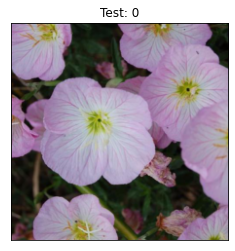

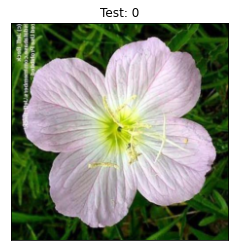

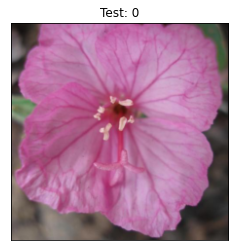

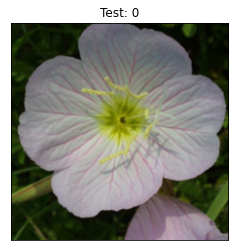

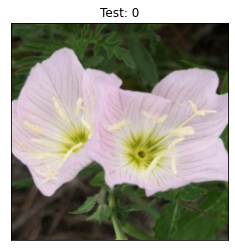

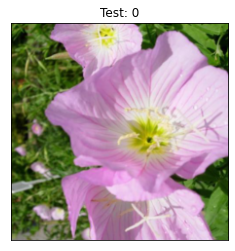

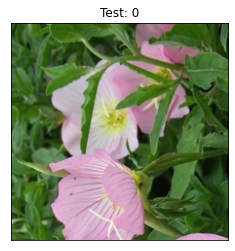

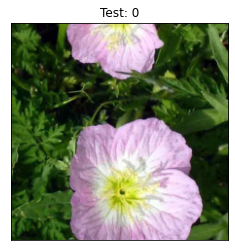

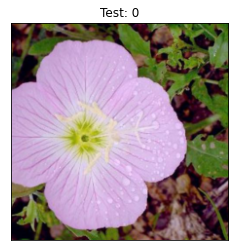

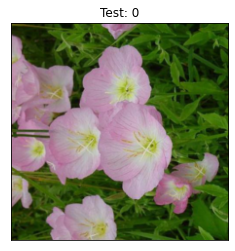

In [6]:
train_examples = [train_dataset[i] for i in range(10)]
for image, label in train_examples:
  image = torch.permute(image, (2, 1, 0)).numpy()
  visualize(image, f'Test: {label}')


In [7]:
class VGG(nn.Module):
  def __init__(self, in_channels=3, num_classes=1000):
    super(VGG, self).__init__()
    
    self.features = nn.Sequential(
      nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(256, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    
    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, num_classes)
    )
    
  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [8]:
model = VGG(in_channels=3, num_classes=102)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  total = 0
  for i, (images, labels) in enumerate(loader[mode]):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')




In [ ]:
model = model.to(device)
epochs = 200
for epoch in range(epochs):
  model.train()
  total = 0
  total_correct = 0
  total_loss = 0
  for i, (images, labels) in enumerate(loader['train']):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total += images.size(0)
    _, predictions = outputs.max(1)
    total_correct += (predictions == labels).sum()
    total_loss += loss.item() * images.size(0)
  accuracy = total_correct / total
  loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
  evaluate(model, loader, device, criterion, mode='valid')

Train epoch 0: Loss(4.6262) Accuracy (0.0069)
valid epoch 0: Loss(4.6250) Accuracy (0.0098)
Train epoch 1: Loss(4.6264) Accuracy (0.0059)
valid epoch 1: Loss(4.6250) Accuracy (0.0098)
Train epoch 2: Loss(4.6263) Accuracy (0.0078)
valid epoch 2: Loss(4.6250) Accuracy (0.0098)
Train epoch 3: Loss(4.6262) Accuracy (0.0059)
valid epoch 3: Loss(4.6250) Accuracy (0.0098)
Train epoch 4: Loss(4.6261) Accuracy (0.0069)
valid epoch 4: Loss(4.6250) Accuracy (0.0098)
Train epoch 5: Loss(4.6262) Accuracy (0.0069)
valid epoch 5: Loss(4.6250) Accuracy (0.0098)
Train epoch 6: Loss(4.6262) Accuracy (0.0078)
valid epoch 6: Loss(4.6250) Accuracy (0.0098)
Train epoch 7: Loss(4.6267) Accuracy (0.0049)
valid epoch 7: Loss(4.6250) Accuracy (0.0098)
Train epoch 8: Loss(4.6261) Accuracy (0.0010)
valid epoch 8: Loss(4.6250) Accuracy (0.0098)
Train epoch 9: Loss(4.6263) Accuracy (0.0020)
valid epoch 9: Loss(4.6250) Accuracy (0.0098)
Train epoch 10: Loss(4.6263) Accuracy (0.0059)
valid epoch 10: Loss(4.6250) Accu

In [ ]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print('Total number of parameters:', total_params)

In [ ]:

trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print('Total number of trainable parameters:', trainable_params)

In [ ]:
evaluate(model, loader, device, criterion, mode='test')


#How do you address model overfitting?